In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import os

In [23]:
def calculate_feature_importance(input_dir, n_folds=5):
    # Initialize lists to store predictions and true values across all folds
    all_y_true = []
    all_y_pred = []

    # Initialize dataframe to store feature importance
    feature_importance_df = pd.DataFrame()

    # K-Fold Cross Validation
    for fold in range(1, n_folds + 1):
        #load training and test sets for this fold
        train = pd.read_csv(os.path.join(input_dir, f'training_data_fold{fold}.csv'), index_col=0)
        test = pd.read_csv(os.path.join(input_dir, f'test_data_fold{fold}.csv'), index_col=0)

        #extract numeric features 
        numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
        features = [col for col in numeric_features if col != 'TSI_days']

        #log transformation
        y_train = np.log1p(train['TSI_days'] / 365)
        y_test = np.log1p(test['TSI_days'] / 365)
        X_train = train[features]
        X_test = test[features]

        #train model
        model = RandomForestRegressor(random_state=42)
        model.fit(X_train, y_train)

        #predict
        y_pred = model.predict(X_test)
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        # Store feature importance for the current fold
        fold_feature_importance = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_,
            'Fold': fold
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_feature_importance], axis=0)

    '''# Calculate overall performance metrics
    overall_mse = mean_squared_error(all_y_true, all_y_pred)
    overall_mae = mean_absolute_error(all_y_true, all_y_pred)
    overall_r2 = r2_score(all_y_true, all_y_pred)

    print(f"Overall MSE: {overall_mse}")
    print(f"Overall MAE: {overall_mae}")
    print(f"Overall R²: {overall_r2}")'''

    return feature_importance_df

## A - bspline dataset

In [24]:
# Example usage
input_dir = './data/derived/smoothed/bspline/'  # Replace with your data directory
feature_importance_df = calculate_feature_importance(input_dir)

# Save the feature importance scores
feature_importance_df.to_csv('feature_importance_all_features.csv', index=False)

In [25]:
feature_importance_df

,Feature,Importance,Fold
0,genome_lrtt,0.310555,1
1,genome_tips,0.003637,1
2,genome_dual,0.005339,1
3,genome_reads,0.002952,1
4,gag_lrtt,0.193497,1
...,...,...,...
72,genome_ambig,0.009507,5
73,gag_ambig,0.005330,5
74,pol_ambig,0.011212,5
75,gp41_ambig,0.004066,5


In [26]:
average_importance = feature_importance_df.groupby('Feature')['Importance'].mean().sort_values(ascending=True)

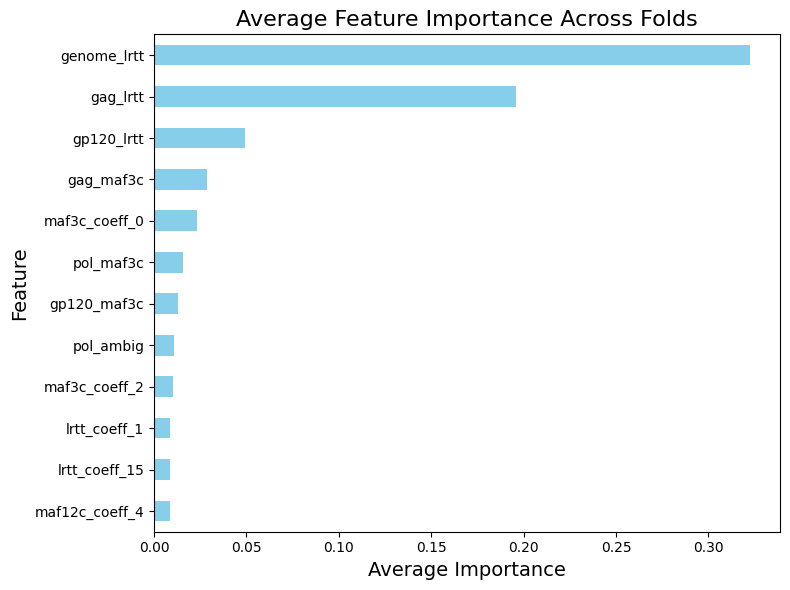

In [34]:
import matplotlib.pyplot as plt
average_importance_sorted = average_importance.sort_values()
importance_threshold = 0.008
important_features = average_importance[average_importance > importance_threshold].sort_values()

plt.figure(figsize=(8, 6))
important_features.plot(kind='barh', color='skyblue')

plt.title('Average Feature Importance Across Folds', fontsize=16)
plt.xlabel('Average Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

# IMPORTANCE VS. CORRELATION WITH TARGET

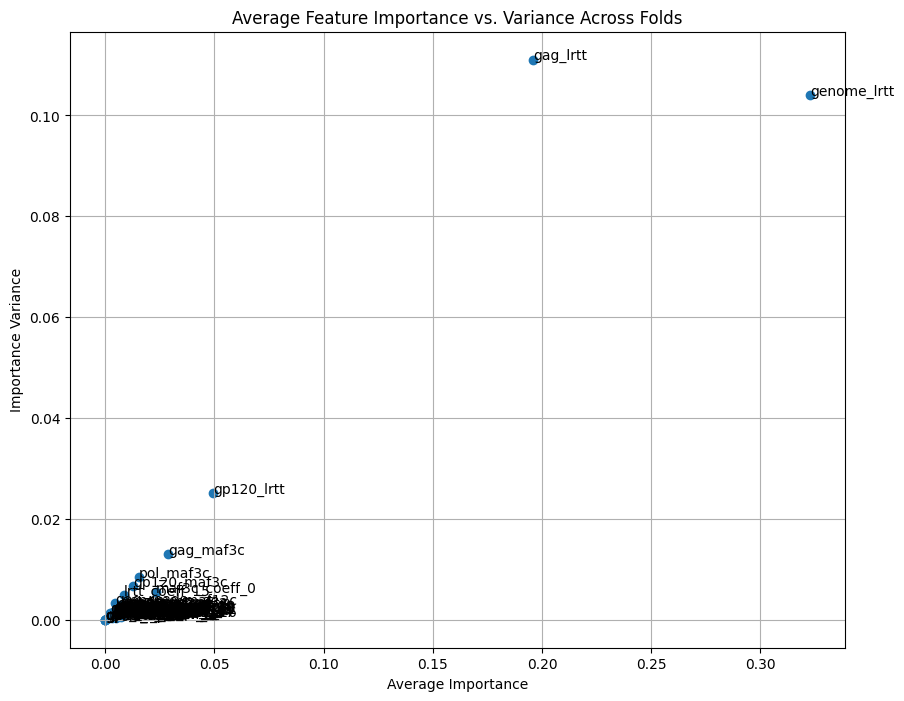

In [33]:
# Assuming `feature_importance_df` is the DataFrame with feature importances from each fold
average_importance = feature_importance_df.groupby('Feature')['Importance'].mean()
importance_variance = feature_importance_df.groupby('Feature')['Importance'].std()

# Combine into a single DataFrame
importance_summary = pd.DataFrame({
    'Average Importance': average_importance,
    'Importance Variance': importance_variance
})

plt.figure(figsize=(10, 8))
plt.scatter(importance_summary['Average Importance'], importance_summary['Importance Variance'])

# Adding labels to the points
for i in range(importance_summary.shape[0]):
    plt.text(importance_summary['Average Importance'].iloc[i], 
             importance_summary['Importance Variance'].iloc[i], 
             importance_summary.index[i])

plt.title('Average Feature Importance vs. Variance Across Folds')
plt.xlabel('Average Importance')
plt.ylabel('Importance Variance')
plt.grid(True)
plt.show()

In [36]:
train = pd.read_csv('./data/derived/feature_selection/training_data_with_dual.csv', index_col = 0)
test = pd.read_csv('./data/derived/feature_selection/training_data_with_dual.csv', index_col = 0)
combined = pd.concat([train, test])

numeric_df = combined.select_dtypes(include=[np.number])

# If the target variable was numeric and got removed, re-add it
if 'target_variable' in combined.columns:
    numeric_df['TSI_days'] = combined['TSI_days']

correlations = numeric_df.corr() 
feature_correlations = correlations['TSI_days'].drop('TSI_days')

In [38]:
# Assuming 'feature_importance' is a pandas Series with feature names as the index
importance_df = pd.DataFrame({'Importance': average_importance})
importance_df['Correlation'] = feature_correlations

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


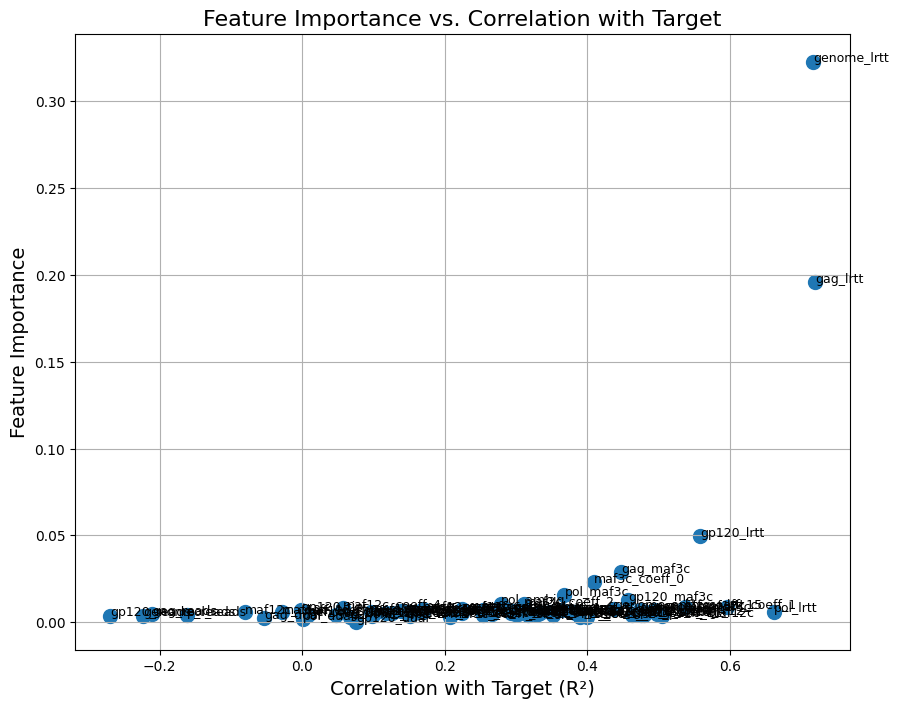

In [41]:
plt.figure(figsize=(10, 8))
plt.scatter(importance_df['Correlation'], importance_df['Importance'], s=100)
for i in range(len(importance_df)):
    plt.text(importance_df['Correlation'].iloc[i], importance_df['Importance'].iloc[i], 
             importance_df.index[i], fontsize=9)
plt.title('Feature Importance vs. Correlation with Target', fontsize=16)
plt.xlabel('Correlation with Target (R²)', fontsize=14)
plt.ylabel('Feature Importance', fontsize=14)
plt.grid(True)
plt.show()

# INTERACTION TERMS

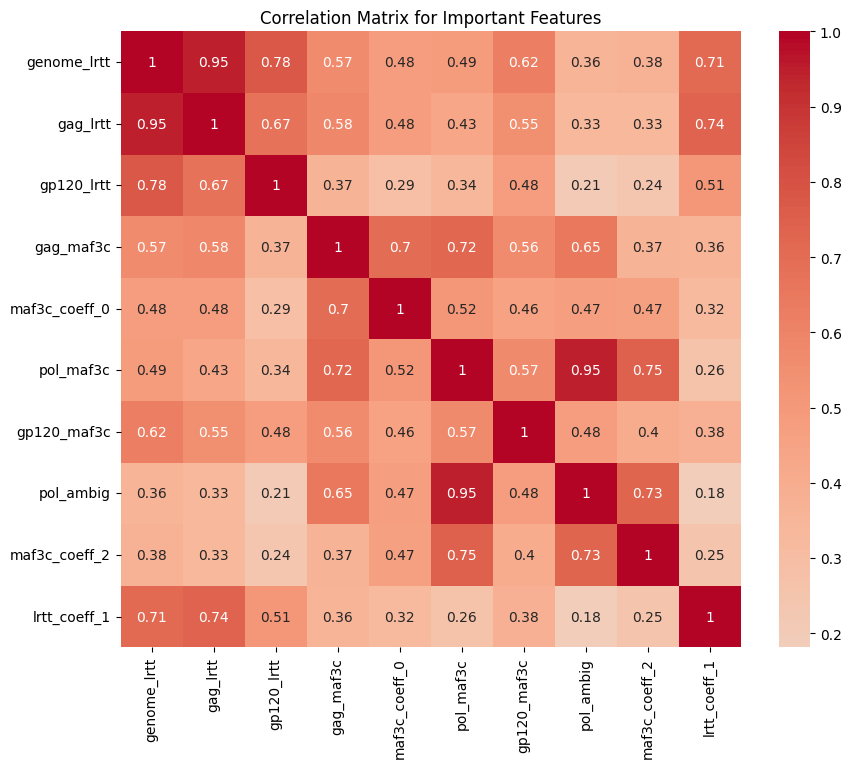

In [47]:
important_features = ['genome_lrtt', 'gag_lrtt', 'gp120_lrtt', 'gag_maf3c', 'maf3c_coeff_0', 'pol_maf3c', 'gp120_maf3c', 'pol_ambig', 'maf3c_coeff_2', 'lrtt_coeff_1']
subset_corr = correlations.loc[important_features, important_features]

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix for Important Features')
plt.show()

In [86]:
correlation_threshold_low = 0.3
correlation_threshold_high = 0.7

# Filter features with moderate to high correlation
moderate_high_corr_features = importance_df[(importance_df['Correlation'].abs() >= correlation_threshold_low) & 
                                         (importance_df['Correlation'].abs() <= correlation_threshold_high)]

selected_features = moderate_high_corr_features.sort_values(by='Importance', ascending=False)
top_5_features = selected_features.sort_values(by='Importance', ascending=False).head(5).index.tolist() #top 5 important features 


In [87]:
from itertools import combinations
interaction_df = pd.DataFrame(index=combined.index)

for i, feature1 in enumerate(top_5_features):
    for feature2 in top_5_features[i+1:]:
        interaction_term_name = f"{feature1}_x_{feature2}"
        interaction_df[interaction_term_name] = combined[feature1] * combined[feature2]

df_with_interactions = pd.concat([combined, interaction_df], axis=1)

print("Interaction terms for the top 5 features created and added to the DataFrame.")

Interaction terms for the top 5 features created and added to the DataFrame.


In [88]:
# Calculate the correlation between the interaction terms and TSI days
interaction_correlations = df_with_interactions[interaction_df.columns].apply(lambda x: x.corr(df_with_interactions['TSI_days']))
sorted_interaction_correlations = interaction_correlations.sort_values(ascending=False)

print("Correlations of interaction terms with the target variable:")
print(sorted_interaction_correlations)

Correlations of interaction terms with the target variable:
gp120_lrtt_x_gag_maf3c         0.603866
gp120_lrtt_x_maf3c_coeff_0     0.586641
gp120_lrtt_x_gp120_maf3c       0.576902
gp120_lrtt_x_pol_maf3c         0.562244
maf3c_coeff_0_x_gp120_maf3c    0.400573
gag_maf3c_x_gp120_maf3c        0.341499
maf3c_coeff_0_x_pol_maf3c      0.275878
gag_maf3c_x_maf3c_coeff_0      0.267649
pol_maf3c_x_gp120_maf3c        0.254231
gag_maf3c_x_pol_maf3c          0.187028
dtype: float64


In [108]:
numeric_df = df_with_interactions.select_dtypes(include=[np.number])
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remove any columns with NaNs or infinite values
numeric_df = numeric_df.replace([np.inf, -np.inf], np.nan)
columns_to_drop = ['gp41_reads', 'gp41_dual', 'gp41_tips', 'gp41_lrtt', 'gp120_dual', 'TSI_days']
numeric_df = numeric_df.drop(columns=columns_to_drop)

# Initialize a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
vif_data_sorted = vif_data.sort_values(by='VIF', ascending=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


            Feature        VIF
41   maf12c_coeff_0        inf
46   maf12c_coeff_5        inf
54  maf12c_coeff_13        inf
53  maf12c_coeff_12        inf
52  maf12c_coeff_11        inf
..              ...        ...
68        gag_ambig  28.640778
13       gp120_tips  25.528673
26     lrtt_coeff_1  18.260706
37    lrtt_coeff_12  13.800136
25     lrtt_coeff_0   5.196973

[82 rows x 2 columns]


In [109]:
vif_data_sorted.to_csv('./data/derived/feature_selection/vif_values.csv', index=False)